# Introduction
A new insturment has arrived at the lab and you want to add it as an option to the measurement software. The aim of this guide is to make adding a new insturment a painless process and requires minimal to no knowledge of the SCPI protocol when doing so.

This tutorial makes the assumption you are doing this in VS Code of VS Studio. If you are coding in a different IDE the instructions should still work, you just may find objects are in different places or with slightly different name.

## LLM

Back in prehistoric times (pre-2022) to automate transforming documentation into code we'd have to write a custom parser to break down the document to write the code. However, unlike the scpi protocol, there is no requirements for how a company writes their documentation. Therefore consturcting a parser to be universal would take a long time and require a rigourous design. So instead we will use an LLM. As we do not want to pay for api access, sadly I could not seemlessly integrate it into this notebook so you, dear user, will have to use your own chat window. Assuming you are in VS Code, I would recommend using the built in Github Copilot feature and you will not have to leave the ide and can easily switch between which LLm you are querying. It is a bit slower than using a web browser, but automatically has the context of the already written code.

For which one to use, I found Claude to be the least error prone when writing code, followed by Gemini 2.5 and then GPT-4. The amount of credits github copilot gives you for free each month should be enough to make about x number of new instruments.

## How to Install and access Github Copilot

Go to the extensions tab on the left sidebar and search copilot and install.

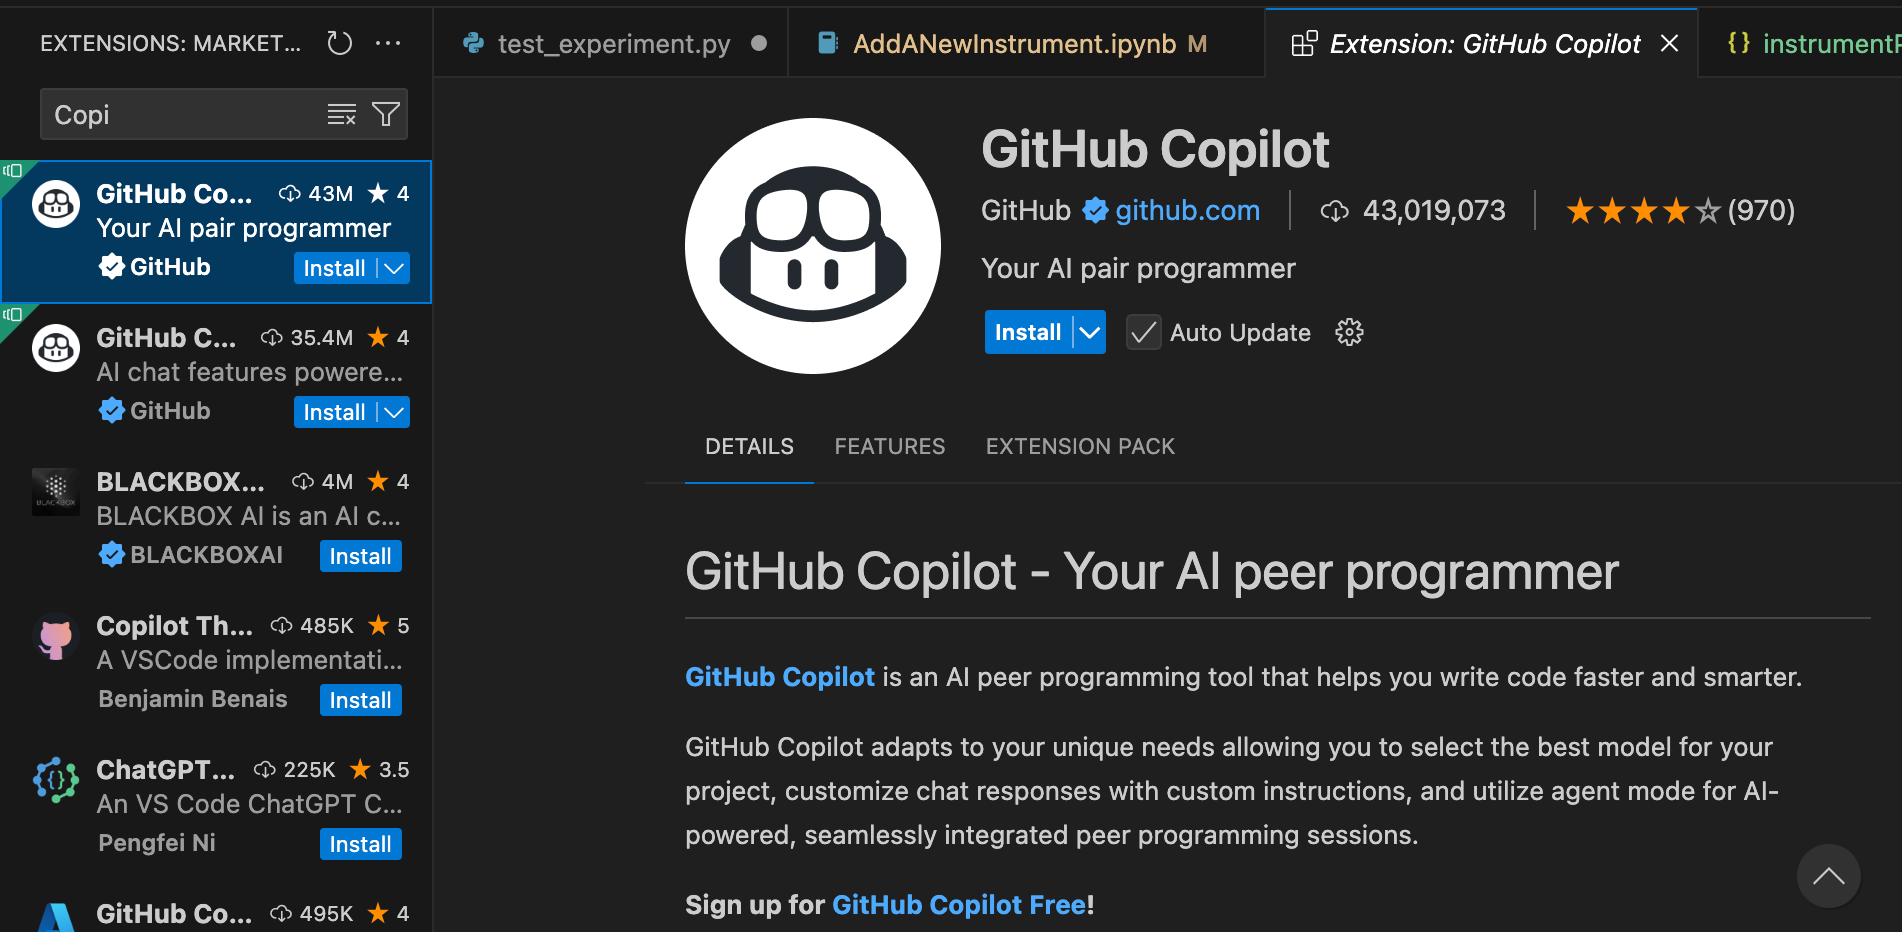

Once installed you will see this icon: 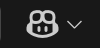 by your search bar. You can set the copilot to auto complete in line code to your preferences, but we will be using the chat feature. Open it with the drop down menu.

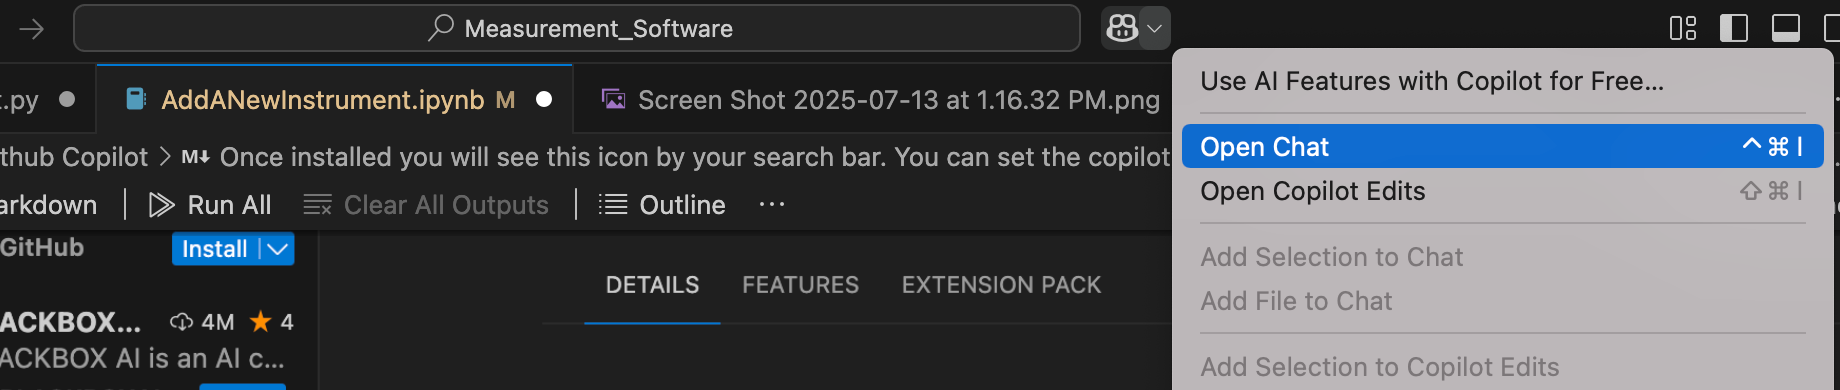

To set up your chat window, select the attachment 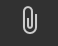 icon and then choose codebase to include the code as context. You can also change what LLM you are querying in the bottom corner.

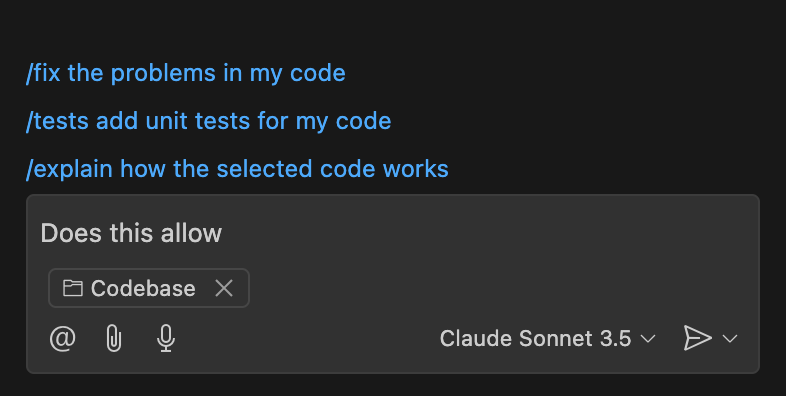

# Add an Instrument

## Create instrument class
First you need to <b>download the instrument's SCPI programming guide</b>. An example of the type of documentation can found in the code base with the name SCPIProgrammingManualRigolOscilloscope.pdf.

You will often find the guide as a part of an SDK package or for download on the distributor's website. Put the documentation in the Documentation folder (Measurement_Software>Instruments>Documentation). Then run the below code.

In [3]:
from PyPDF2 import PdfWriter, PdfReader
import pdf2image
import os
documentation_path = "Documentation/VNASCPIDocumentation" #insert documentation relative path from this file
documentation = PdfReader(open(documentation_path+".pdf","rb")) 
text = ""
for p in documentation.pages:
    text = text + p.extract_text()
with open(documentation_path+".txt", "w") as f:
    f.write(text)


Run the below code to produce prompt to copy. Make sure to attached your text document as context.

In [ ]:
prompt = "List all the pages where a new scpi command grouping begins in "+ documentation_path+".txt. Put it in the format [3,5,...]."
print(prompt)

List all the pages where a new scpi command grouping begins in Documentation/VNASCPIDocumentation.txt. Put it in the format [3,5,...].


Copy the list the LLM spits out into the variable below page_break_up.

In [6]:
#Break up pdf into scpi command sections
#This helps prevent the LLM from getting overwhelmed and missing a command
page_break_up = [34, 40, 185, 212, 215, 217, 220, 238, 239, 356, 381, 383, 384, 386, 388, 392, 400, 412, 415, 427, 434, 435, 449] #Paste list here

documentation = PdfReader(open(documentation_path+".pdf","rb")) #insert documentation relative path
print(len(documentation.pages))
for i in range(len(page_break_up)):
    writer = PdfWriter()
    text = ""
    if i+1 == len(page_break_up):
        end_index = len(documentation.pages)
    else:
        end_index = page_break_up[i+1]+1
    for j in range(page_break_up[i], end_index):
        writer.add_page(documentation.pages[j])
        text = text+ documentation.pages[j].extract_text()
    with open(f"Documentation/section%s.txt" % i, "w") as f:
        f.write(text)
    



484


Copy the file template_instrument.py and rename it in the format [instrument type]_[Manufacturer].py. Modify the self.name variable to make the instrument's name. You will copy the code the LLM spits out into this file. Sadly due to not having api access, there isn't really a cleaner way to automate this.

Now you have several txt files with the file name format sectionN.txt. All LLM's get confused if you attempt to have them write too much code at once so I'd recommend providing one to four sectionN.txt files at once depending on their length. Sometimes a single text is too largeCopy the prompt below, attach the next couple .txt files at context. Then copy the code and paste it into the instrument class. There is a feature called agent were the llm can make changes to your code directlyRepeat until all .txt sections have been completed.

As you copy the code over, do check that it all looks as expected. LLMs are far from perfect and will mess up. Ask the chat to tweak the provided code and occasionaly you may need to provide the same text file twice when a command table is split between two pages in the documentation.

For the first group of section attach the oscillscope_rigol.py and use the first prompt listed. After the first group of functions has been saved to [instrument type]_[Manufacturer].py, use the second prompt and only attach the sectionN.txt files.

In [7]:
instrument_class = "Instruments/vector_network_analyzer_copper_mountain.py"
Firstprompt = "Finish "+instrument_class+" code with similar get and set or enable and is_..._enabled python functions like in oscilloscope_rigol.py for attached section text files. Use the shorten version of SCPI commands which is the capitalized part of the command in the section text files. Include optional nodes i.e. [:SENS]. Check string arguments are one of the allowed values. All SCPI commands should start with : and use 1 and 0 not '1' and '0'. Only include new functions not already in "+instrument_class+". Exclude the IEEE 488.2 commands."
print(Firstprompt)

Finish Instruments/vector_network_analyzer_copper_mountain.py code with similar get and set or enable and is_..._enabled python functions like in oscilloscope_rigol.py for attached section text files. Use the shorten version of SCPI commands which is the capitalized part of the command in the section text files. Include optional nodes i.e. [:SENS]. Check string arguments are one of the allowed values. All SCPI commands should start with : and use 1 and 0 not '1' and '0'. Only include new functions not already in Instruments/vector_network_analyzer_copper_mountain.py. Exclude the IEEE 488.2 commands.


In [ ]:
prompt = "Finish "+instrument_class+" code with similar get and set or enable and is_..._enabled python functions for attached section text files. Use the shorten version of SCPI commands which is the capitalized part of the command in the section text files. Include optional nodes i.e. [:SENS]. Check string arguments are one of the allowed values. All SCPI commands should start with : and use 1 and 0 not '1' and '0'. Only include new functions not already in "+instrument_class+". Exclude the IEEE 488.2 commands."
print(prompt)

In [8]:
#Run this code to remove all the text files
#This is primary to keep the github clean.

documentation = PdfReader(open(documentation_path+".pdf","rb")) #insert documentation relative path
print(len(documentation.pages))
for i in range(len(page_break_up)):
    #TODO: Look up how to delete
    os.remove(f"Documentation/section%s.txt" % i)

484


#TODO: Add overlap and replacement checks experiment with doing it before. Leave this for last.

Most SCPI documentation has a table of contents where the entire command tree. 

# Instrument Unit Tests

It is considered good practice to test all of your functions before using them in production. Use the following prompt to create a test file.

<b>Prompt</b>: Create a file to test all the functions in the [insert instrument python file]. Following the format found in test_oscilloscope.py

TODO: Check max amount of tests it will produce at once.

<b>End Prompt.</b>

Create a file in the Testing folder with the name format test_[name of instrument].py (i.e test_oscilloscope.py) and copy the suggested code into the file.

# How to Run Tests

If you are in vs code, the IDE already has a built in testing helper. But first you need to connect the instrument to the measurement PC and update the port table.

## Update JSON Table

After the instrument is connected either to the PHOQis router or directly into the measurement PC run the below script to add the instrument to the json file for saving the port name.

In [4]:
import pyvisa
import json

rm = pyvisa.ResourceManager()
resources = rm.list_resources()
#TODO Test this
name = "Name" #Update with the same value as self.name in the primary instrument class
with open('instrumentPorts.json', 'r') as f:
    instrument_ports = json.load(f)

for r in resources:
    if r not in instrument_ports.values():
        instrument_ports[name] = r

with open('instrumentPorts.json', 'w') as f:
    json.dump(instrument_ports, f)
        


ModuleNotFoundError: No module named 'pyvisa'

## Run Tests in vs code
Go to vs code sidebar and select the testing icon: 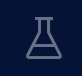

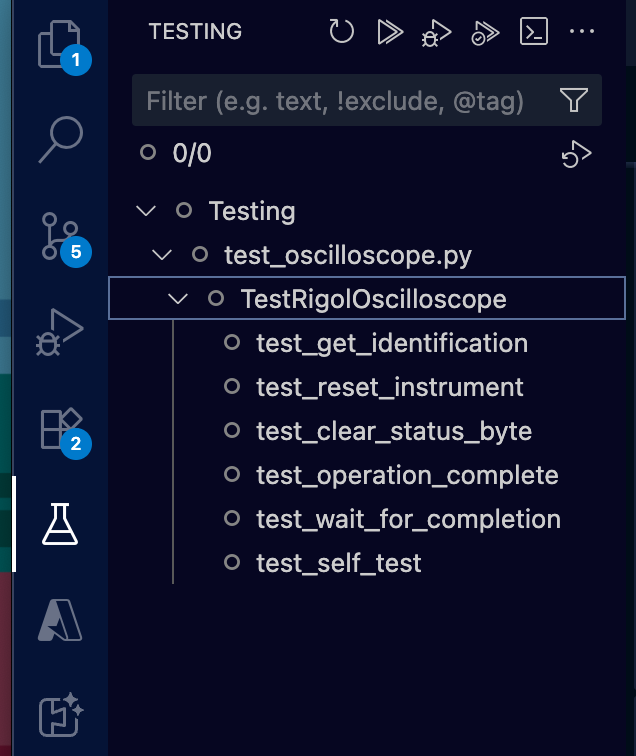


If no test automatically pop up use the shortcut cmd/ctrl + Shift + P to open the command palette and then type Python: Configure Test.

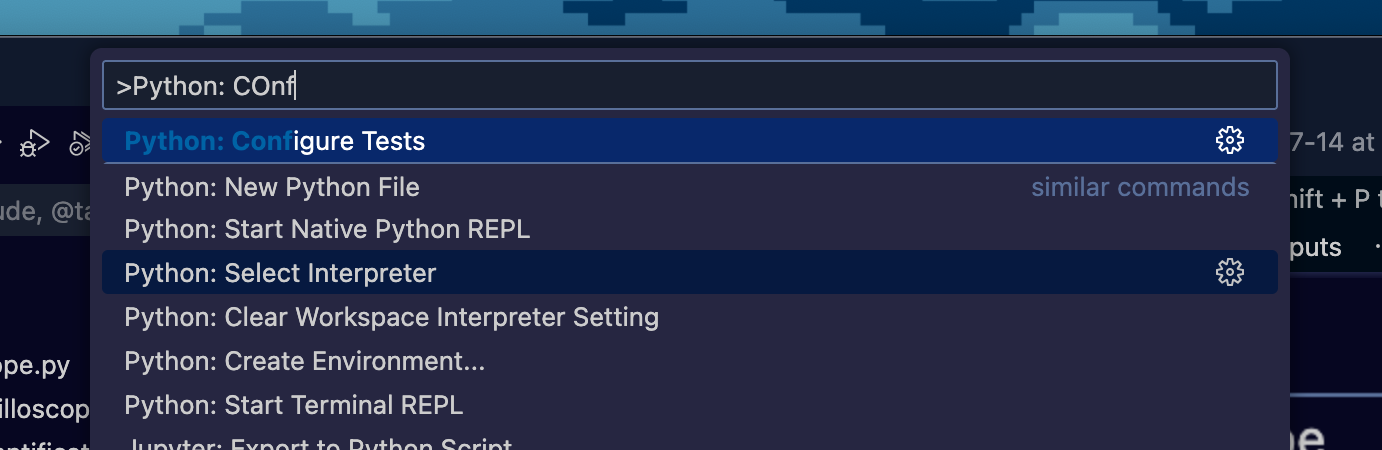

The choose to configure to unittests. Then choose the Testing folder. Then select 'test_*.py' as the testing file naming convention.

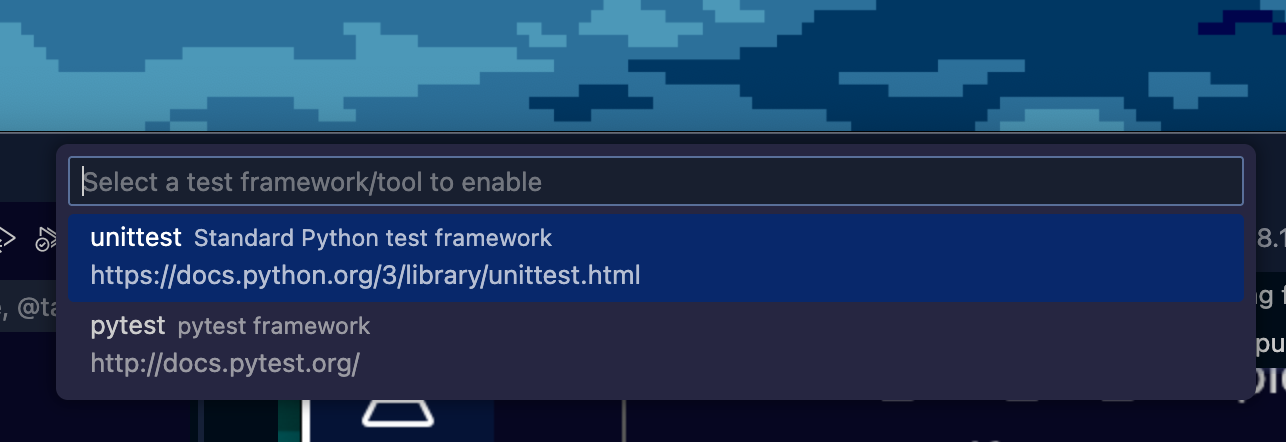

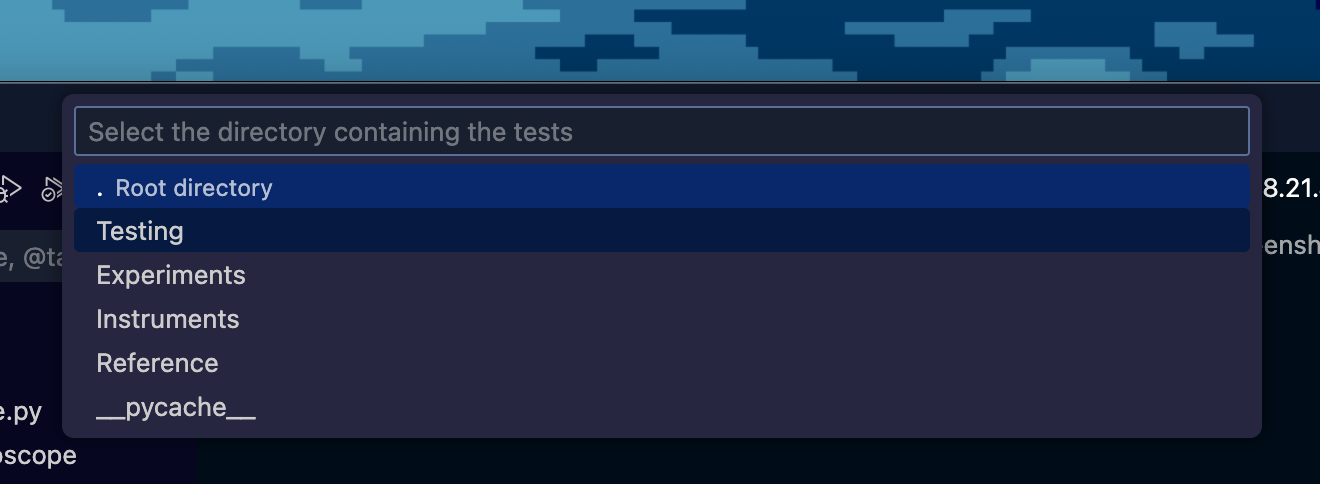

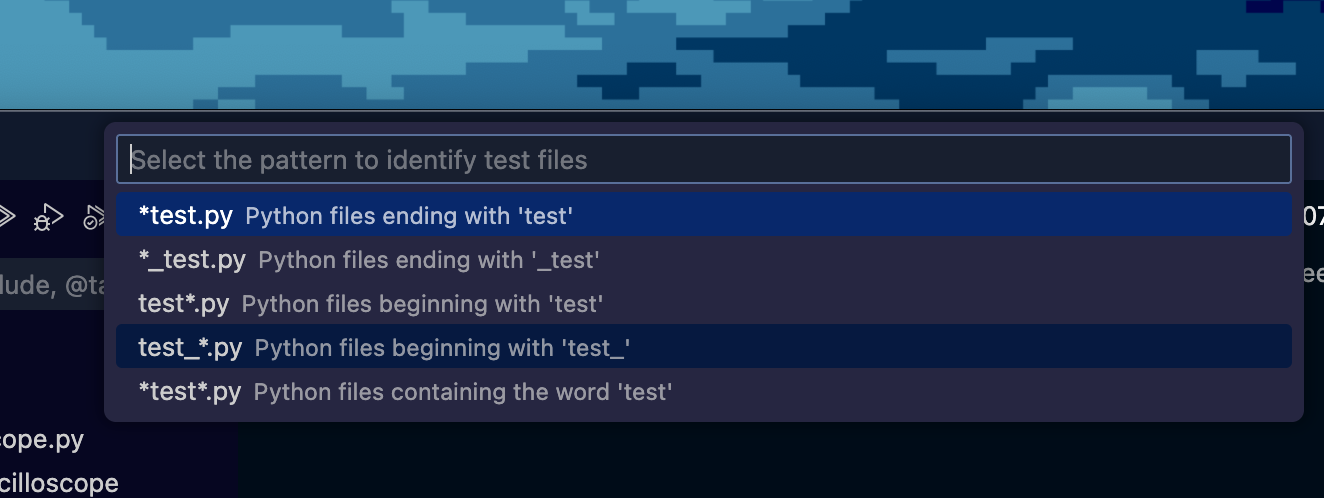

# Create Instrument Helper Class

Some sequences of SCPI commands will be used over and over again. For example setting a display to a specfic size or turning on certain channels. Some examples can be found in the oscilloscope_helper.py.

First copy the file template_helper.py and rename to format is instrument_name_helper.py. Rather than using generative ai, I would recommend creating your own functions based on your and the labs needs.

Make sure the correct instrument name is assigned to the helper so it's valid instrument checks are correct.

Congradulations! You have successfully set up a new instrument. Push your code to the git and feel free to start using your new instrument in test experiments.